In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
from PIL import Image
import os

# Check for Apple Silicon GPU (MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
class PricePredictor(nn.Module):
    def __init__(self):
        super(PricePredictor, self).__init__()
        self.cnn = models.resnet18(weights='DEFAULT')
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity() 

        self.fc_numerical = nn.Sequential(
            nn.Linear(15,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,32),
            nn.ReLU()
        )

        # Combined fully connected layers
        self.fusion = nn.Sequential(
            nn.Linear(num_ftrs + 32, 64),
            nn.ReLU(),
            nn.Linear(64,1)  # Output layer for price prediction
        )

    def forward(self, image, tabular):
        vis_features = self.cnn(image)
        tab_features = self.fc_numerical(tabular)
        combined = torch.cat((vis_features, tab_features), dim=1)
        return self.fusion(combined)
model = PricePredictor().to(device)
print(model)
        

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/tanishakumari/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


PricePredictor(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [7]:
class MultimodalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        self.features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                         'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
                         'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        tab_data = torch.tensor(row[self.features].values.astype(float), dtype=torch.float32)
        
        img_id = int(row['id'])
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        target = torch.tensor(row['log_price'], dtype=torch.float32)
        
        return image, tab_data, target

In [8]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = MultimodalDataset('../data/train_final.csv', '../data/images/', transform=data_transforms)
val_dataset = MultimodalDataset('../data/val_final.csv', '../data/images/', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Data Loaders ready: {len(train_loader)} training batches, {len(val_loader)} validation batches.")

Data Loaders ready: 406 training batches, 102 validation batches.


In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5  
best_val_loss = float('inf')

print("Starting Training on MPS/GPU...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, tabular, targets in train_loader:
        images, tabular, targets = images.to(device), tabular.to(device), targets.to(device)
        targets = targets.view(-1, 1) 
        
        optimizer.zero_grad()
        
        outputs = model(images, tabular)
        loss = criterion(outputs, targets)
    
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for images, tabular, targets in val_loader:
            images, tabular, targets = images.to(device), tabular.to(device), targets.to(device)
            targets = targets.view(-1, 1)
            outputs = model(images, tabular)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            
    val_loss = val_loss / len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../models/best_multimodal_model.pth')
        print("--> New best model saved to /models/!")

print("Training Complete! You have successfully built a Multimodal AI.")

Starting Training on MPS/GPU...
Epoch 1/5 | Train Loss: 2.7836 | Val Loss: 0.1242
--> New best model saved to /models/!
Epoch 2/5 | Train Loss: 0.0946 | Val Loss: 0.0783
--> New best model saved to /models/!
Epoch 3/5 | Train Loss: 0.0848 | Val Loss: 0.0686
--> New best model saved to /models/!
Epoch 4/5 | Train Loss: 0.0767 | Val Loss: 0.0689
Epoch 5/5 | Train Loss: 0.0709 | Val Loss: 0.0693
Training Complete! You have successfully built a Multimodal AI.


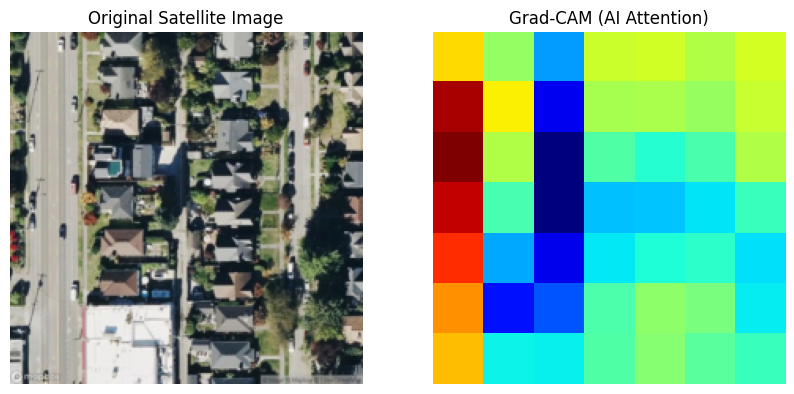

In [18]:


def generate_grad_cam(model, image_tensor, tabular_tensor):
    model.eval()
    
    target_layer = model.cnn.layer4[-1]
    
    activations = {}
    def get_activations(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    gradients = {}
    def get_gradients(name):
        def hook(model, grad_input, grad_output):
            gradients[name] = grad_output[0]
        return hook

    target_layer.register_forward_hook(get_activations('fwd'))
    target_layer.register_full_backward_hook(get_gradients('bwd'))

    output = model(image_tensor.unsqueeze(0).to(device), tabular_tensor.unsqueeze(0).to(device))
    
    model.zero_grad()
    output.backward()

    grads = gradients['bwd']
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    act = activations['fwd'].squeeze(0)
    
    for i in range(act.shape[0]):
        act[i, :, :] *= pooled_grads[i]
        
    heatmap = torch.mean(act, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    
    heatmap /= (np.max(heatmap) + 1e-8)
    
    return heatmap

img_t, tab_t, target_t = val_dataset[10] 
heatmap = generate_grad_cam(model, img_t, tab_t)

heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
img_display = img_t.permute(1, 2, 0).cpu().numpy()
img_display = (img_display * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
plt.imshow(np.clip(img_display, 0, 1))
plt.title("Original Satellite Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM (AI Attention)")
plt.axis('off')

plt.show()

In [22]:
import numpy as np
import joblib

test_csv_path = '../data/test_cleaned.csv' 
scaler_path = '../models/feature_scaler.pkl'

test_df = pd.read_csv(test_csv_path)
scaler = joblib.load(scaler_path)

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

test_df_scaled = test_df.copy()
test_df_scaled[features] = scaler.transform(test_df[features])

model.eval() 
all_preds = []

print(f"Starting predictions for {len(test_df)} entries...")

with torch.no_grad():
    for idx, row in test_df_scaled.iterrows():
        tab_tensor = torch.tensor(row[features].values.astype(float), dtype=torch.float32).unsqueeze(0).to(device)
        
        img_id = int(row['id'])
        img_path = f"../data/images/{img_id}.jpg"
        
        try:
            image = Image.open(img_path).convert('RGB')
            img_tensor = data_transforms(image).unsqueeze(0).to(device)
            
            log_pred = model(img_tensor, tab_tensor)
            
            actual_price = np.expm1(log_pred.item())
            all_preds.append(actual_price)
        except FileNotFoundError:
            print(f"Warning: Image {img_id}.jpg not found. Skipping or using average.")
            all_preds.append(0) 

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': all_preds
})

submission_df.to_csv(f'../24123045_final.csv', index=False)
print(f"✓ Success! File saved as 24123045_final.csv")

Starting predictions for 5404 entries...
✓ Success! File saved as 24123045_final.csv
